In [9]:
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import scipy.constants as const
import warnings
warnings.filterwarnings('ignore')
from modelfitting import rotationalProfile

In [4]:
# Open data
data_filename = '../data/fainterspectral-fits_6.pickle'
with open(data_filename, 'rb') as f:
    ret = pickle.load(f, encoding="latin1")

# In this tutorial just use data from one wavelength band 
band = 0

In [5]:
# Open model
from astropy.table import Table
model_filename = '../data/BT-Settl_lte015-5.0-0.0+0.0_orig.fits'
model = Table.read(model_filename, format='fits')
model['wl'] = model['Wavelength']
model['flux'] = model['Flux']

lowerlim = ret['wobs'][band].min() - 0.003  # TODO: where this value from
upperlim = ret['wobs'][band].max() + 0.003
tind = (model['wl'] > lowerlim) * (model['wl'] < upperlim) # get index of template spec where wl covered by obs
lam_template = model['wl'][tind]
template = model['flux'][tind]
template = template/np.median(template) # normalize flux wrt to template median level in this wl band

In [10]:
vsini = 2.75467419e+01 # km/s
lld = 2.42449751e-01
rv = 1.50501728e-04 # rv/c
wavelength_coefs = [-1.71924678e-14, -2.11171020e-04,  1.30434527e-02,  2.28755948e+00]
continuum_coefs = [-1.98152556e-02, 1.09272772e+00]
npix = 1024
lam_template = np.array(lam_template, copy=False)
template = np.array(template, copy=False)
pix = np.arange(npix, dtype=float)/npix

In [15]:
lam_template.mean()

2.2939024

In [13]:
np.diff(lam_template)

array([5.00679e-06, 5.00679e-06, 5.00679e-06, ..., 5.00679e-06,
       5.00679e-06, 5.00679e-06], dtype=float32)

In [24]:
# Create model-convolution Kernel and convolve template:
dlam = np.diff(lam_template).mean()
mean_lam = lam_template.mean()
pixsize_ms = const.c * dlam / mean_lam
print("pixsize_ms:", pixsize_ms)

kern_edge = int(1200.*vsini/pixsize_ms) # TODO: 1200??
xkern = np.arange(-kern_edge, kern_edge+1)
print("xkern:", xkern)

pixsize_ms: 653.4592146333782
xkern: [-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50]


In [23]:
dv = xkern * pixsize_ms # wavelength offset
dv

array([-32672.96073167, -32019.50151704, -31366.0423024 , -30712.58308777,
       -30059.12387314, -29405.6646585 , -28752.20544387, -28098.74622924,
       -27445.2870146 , -26791.82779997, -26138.36858534, -25484.9093707 ,
       -24831.45015607, -24177.99094143, -23524.5317268 , -22871.07251217,
       -22217.61329753, -21564.1540829 , -20910.69486827, -20257.23565363,
       -19603.776439  , -18950.31722437, -18296.85800973, -17643.3987951 ,
       -16989.93958047, -16336.48036583, -15683.0211512 , -15029.56193657,
       -14376.10272193, -13722.6435073 , -13069.18429267, -12415.72507803,
       -11762.2658634 , -11108.80664877, -10455.34743413,  -9801.8882195 ,
        -9148.42900487,  -8494.96979023,  -7841.5105756 ,  -7188.05136097,
        -6534.59214633,  -5881.1329317 ,  -5227.67371707,  -4574.21450243,
        -3920.7552878 ,  -3267.29607317,  -2613.83685853,  -1960.3776439 ,
        -1306.91842927,   -653.45921463,      0.        ,    653.45921463,
         1306.91842927,  

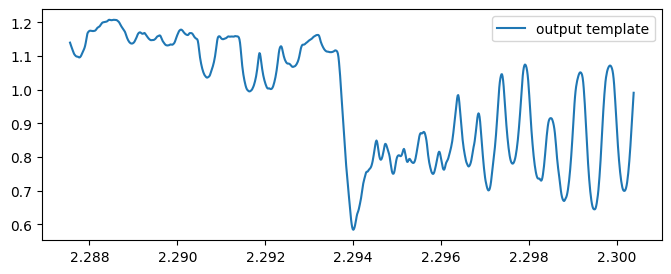

In [31]:
dv = xkern * pixsize_ms
rotational_profile = rotationalProfile([vsini*1000., lld, 0], dv)
rotational_profile /= rotational_profile.sum()

new_template = np.convolve(template, rotational_profile, 'same')

# Shift template to specified RV & interpolate to wavelength grid

lam = np.polyval(wavelength_coefs, pix)
result_template = np.interp(lam, lam_template*(1.+rv), new_template, left=0., right=0.)

# Multiply by appropriate normalization polynomial
result_template *= np.polyval(continuum_coefs, pix)
plt.figure(figsize=(8,3))
plt.plot(lam, result_template, label="output template")
plt.legend()
plt.show()

#### Rotational profile

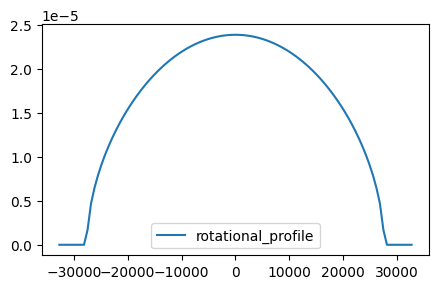

In [34]:
from cProfile import label


delta_lambda_L = vsini*1000. # in m/s; lambda * V * sin(i)/c; the rotational displacement at the stellar limb.
eps = lld                    # linear limb darkening coeff
delta_lam = dv               # array of offset from wl center (len=100)

lamdel2 = 1. - (delta_lam/delta_lambda_L)**2
rot_profile = (4*(1.-eps) * np.sqrt(lamdel2) + np.pi*eps*lamdel2) / (2*np.pi * delta_lambda_L * (1. - eps/3.))
rot_profile[lamdel2<0] = 0.
plt.figure(figsize=(5,3))
plt.plot(delta_lam, rot_profile, label="rotational_profile")
plt.legend()
plt.show()